<a href="https://colab.research.google.com/github/tsilva/aiml-notebooks/blob/main/misc/wip-mnist-denoising-with-autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Denoising MNIST with an Autoencoder

In this notebook we are going to train an autoencoder model to remove noise from noisy MNIST images.

## Setup

First, let's install the necessary packages for our project:
- PyTorch: Deep learning framework for building our neural networks
- tsilva-notebook-utils: Utility functions for notebook visualizations
- Gradio: Library for creating interactive UI components


In [18]:
!pip install torch # We'll need PyTorch
!pip install tsilva-notebook-utils # Misc utilities to facilitate building of notebooks
!pip install gradio # We'll build a gradio ui at the end of the notebook

Let's define our model configuration parameters that will control the architecture and training process:


In [19]:
CONFIG = {
    "seed": 42,              # Random seed for reproducibility across runs (e.g., initializing weights, shuffling data)
    "input_size": 784,       # Input dimension of the data (28x28 pixels = 784, typically flattened MNIST images)
    "hidden_size": 256,      # Number of units in the hidden layer(s) of the neural network (e.g., encoder/decoder)
    "latent_size": 128,      # Size of the latent space (e.g., bottleneck in an autoencoder or VAE)
    "train_batch_size": 64,  # Number of samples per batch during training (balances speed and gradient stability)
    "test_batch_size": 64,   # Number of samples per batch during testing (often matches train_batch_size for consistency)
    "n_epochs": 10,          # Number of full passes through the training dataset
    "learning_rate": 0.001,  # Step size for gradient descent optimization (controls how fast the model learns)
    "noise_factor": 0.5      # Factor of noise to add (e.g., for denoising tasks, scales intensity of added noise)
}

Let's set a random seed to ensure reproducibility of our results across runs. This controls the initialization of random numbers in Python, NumPy, and PyTorch:


In [20]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)  # Set the seed for Python's built-in random number generator
    np.random.seed(seed)  # Set the seed for NumPy's random number generator
    torch.manual_seed(seed)  # Set the seed for PyTorch's CPU random number generator
    torch.cuda.manual_seed(seed)  # Set the seed for PyTorch's CUDA (GPU) random number generator, if GPU is available
    torch.backends.cudnn.deterministic = True  # Force CuDNN (CUDA Deep Neural Network library) to use deterministic algorithms for reproducibility
    torch.backends.cudnn.benchmark = False  # Disable CuDNN's benchmarking feature, which optimizes for speed but may introduce randomness

seed = CONFIG["seed"]
set_seed(seed)

Now we determine whether to use GPU (CUDA) or CPU for training. Using GPU when available significantly accelerates the neural network training process:


In [21]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare Dataset

Let's download the MNIST dataset (handwritten digits) and create data loaders that will efficiently feed batches of images to our model during training and testing:


In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Load train dataset and create loader
train_batch_size = CONFIG["train_batch_size"]
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

# Load test dataset and create loader
test_batch_size = CONFIG["test_batch_size"]
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

Let's display a sample image from the dataset to visualize what our model will be working with (run cell multiple times to see different digit samples):


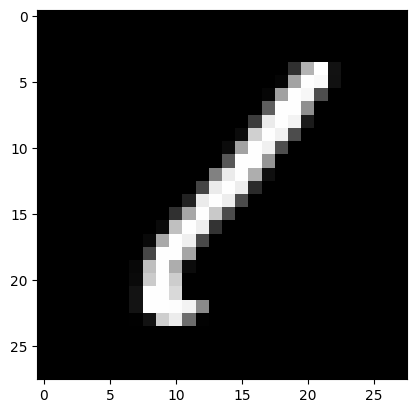

In [23]:
import matplotlib.pyplot as plt

def render_image_tensor(image):
    image *= 255                    # Multiply by 255 to convert pixel values from 0-1 range to 0-255 (standard RGB scale)
    image = image.squeeze()         # Remove singleton dimensions (e.g., channel dim) since this is grayscale, not multi-channel
    image = image.cpu()             # Move the tensor to CPU memory, as GPU tensors can't be directly converted to NumPy
    image = image.detach()          # Detach the tensor from the computation graph to prevent tracking gradients
    image = image.numpy()           # Convert the PyTorch tensor to a NumPy array for visualization
    image = image.astype("uint8")   # Cast to unsigned 8-bit integer type, required for proper image display
    plt.imshow(image, cmap="gray")  # Display the image using matplotlib with a grayscale colormap

# Sample first batch from training set
first_batch = next(iter(train_loader))[0]

# Retrieve first image from batch
first_image = first_batch[0]

# Store image dimensions for later reference
IMAGE_WIDTH = first_image.shape[0]
IMAGE_HEIGHT = first_image.shape[1]

# Render the image
render_image_tensor(first_image)

Let's create functions to apply controlled random noise to our images and display examples of original vs. noisy image pairs:


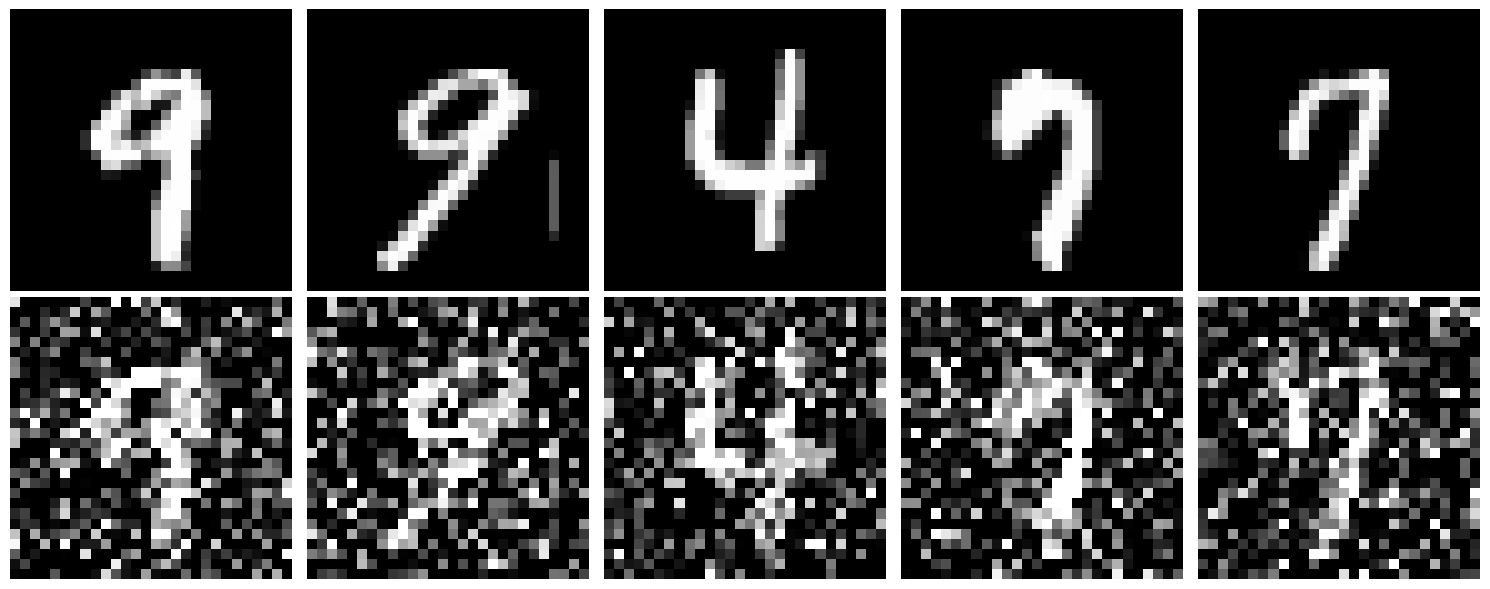

In [24]:
def sample_noise(tensor, noise_factor=None):
    if noise_factor is None: noise_factor = CONFIG["noise_factor"]

    # Sample noise with same shape as tensor
    noise = torch.randn_like(tensor)

    # Scale down noise by the specified factor
    scaled_noise = noise * noise_factor

    # Return scaled noise
    return scaled_noise

def add_noise_to_tensors(tensors, noise=None):
    # Sample default noise if none was provided
    if noise is None: noise = sample_noise(tensors)

    # Add noise to tensor
    noisy_tensors = tensors + noise

    # Clip tensor to ensure all its values remain within range (0-1)
    clipped_noisy_tensors = torch.clamp(noisy_tensors, 0., 1.)

    # Return clipped noisy tensor
    return clipped_noisy_tensors

def tensor_to_image_data(tensor):
    def process_tensor(t):
        # Convert tensor to NumPy array, scale to 0-255, and cast to uint8
        return (t.squeeze().cpu().detach().numpy() * 255).astype(np.uint8)

    # Check if tensor is a list/tuple of lists/tuples (for multi-row data)
    is_list_of_lists = isinstance(tensor, (list, tuple)) and all(isinstance(t, (list, tuple)) for t in tensor)
    data_to_process = tensor if is_list_of_lists else [[tensor]]  # Wrap single tensor for consistency

    # Process tensors into image data
    processed_images = []
    for col, pair in enumerate(data_to_process):
        col_images = [process_tensor(t) for t in pair]
        processed_images.append(col_images)

    # Return single image if not list-of-lists, otherwise list of lists
    return processed_images[0][0] if not is_list_of_lists else processed_images

def show_tensor_images(tensor):
    # Convert tensor to image data using the conversion function
    image_data = tensor_to_image_data(tensor)

    # Determine layout based on input structure
    is_list_of_lists = isinstance(image_data, list) and all(isinstance(col, list) for col in image_data)
    cols = len(image_data)
    rows = len(image_data[0]) if is_list_of_lists else 1

    # Create plot
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3), squeeze=False)
    for col, col_images in enumerate(image_data):
        if not is_list_of_lists:
            col_images = [col_images]  # Wrap single image in list for iteration
        for row, img in enumerate(col_images[:rows]):
            axes[row, col].imshow(img, cmap="gray")
            axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

images = next(iter(train_loader))[0][:5]
noisy_images = add_noise_to_tensors(images)
show_tensor_images(list(zip(images, noisy_images)))

## Build Model

Now we'll build our autoencoder model with encoder and decoder components. The encoder compresses the input to a lower-dimensional latent space, while the decoder reconstructs the original image from this compressed representation:


In [25]:
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        latent_size
    ):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder (progressively squeezes input
        # to lower dimensional representation)
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size),
            nn.ReLU()
        )

        # Decoder (progressively increases dimensionality
        # from latent space presentation to output dimensionality)
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def build_model(
    input_size=None,
    hidden_size=None,
    latent_size=None
):
    if input_size is None: input_size = CONFIG["input_size"]
    if hidden_size is None: hidden_size = CONFIG["hidden_size"]
    if latent_size is None: latent_size = CONFIG["latent_size"]

    model = DenoisingAutoencoder(input_size, hidden_size, latent_size)
    return model

# Build model and send it to device
model = build_model()
model = model.to(DEVICE)

Our model works with flattened 1D tensors (784 pixels), while MNIST images are 2D (28×28). Let's create utility functions to convert between these formats:


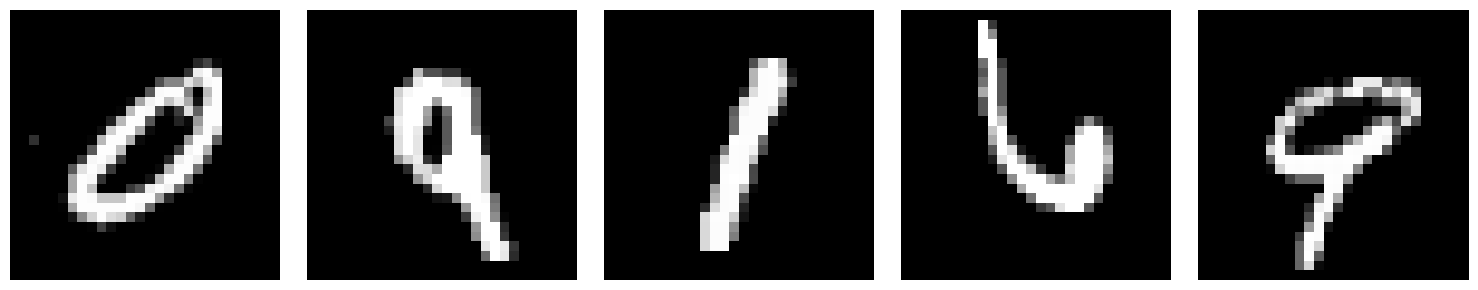

In [26]:
def flatten_images(images):
  return images.view(images.size(0), -1)

def unflatten_images(flattened_images):
  return flattened_images.view(flattened_images.size(0), 1, 28, 28)

images = next(iter(train_loader))[0][:5]
images = unflatten_images(flatten_images(images))
show_tensor_images(images)

To monitor our model's performance and ensure it generalizes well beyond the training data, let's create an evaluation function that measures the denoising accuracy on our test dataset:


In [27]:
def evaluate(model, data_loader):
    # Set model in evaluation mode
    model.eval()

    # Create the loss (mean squared error)
    criterion = nn.MSELoss()

    # Calculate mean loss across dataset
    # served by provided loader
    losses = []
    with torch.no_grad():
        for data in data_loader:
            # Load image batch and send it to device
            images, _ = data
            images = images.to(DEVICE)

            # Flatten images so that they match model input/output shapes
            flattened_images = flatten_images(images)

            # Add noise to images
            flattened_noisy_images = add_noise_to_tensors(flattened_images)

            # Forward pass
            output = model(flattened_noisy_images)

            # Calculate and collect loss
            loss = criterion(output, flattened_images)
            losses.append(loss.item())

    # Return mean loss
    mean_loss = torch.tensor(losses).mean()
    return mean_loss

evaluate(model, test_loader)

tensor(0.2312)

Let's implement and execute the training loop, where the model will learn to map noisy images to their clean versions through multiple epochs of optimization:


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

def train(
    model,
    train_loader,
    test_loader,
    n_epochs=None,
    learning_rate=None,
    noise_factor=None
):
    if n_epochs is None: n_epochs = CONFIG["n_epochs"]
    if learning_rate is None: learning_rate = CONFIG["learning_rate"]

    # Create the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create the loss (mean squared error)
    criterion = nn.MSELoss()

    # Train for N epochs
    for epoch in range(n_epochs):
        # Set model in training mode
        model.train()

        # Train
        train_losses = []
        for data in train_loader:
            # Load image batch and send it to device
            images, _ = data
            images = images.to(DEVICE)

            # Flatten images so that they match model input/output shapes
            flattened_images = flatten_images(images)

            # Add noise to images
            flattened_noisy_images = add_noise_to_tensors(flattened_images)

            # Forward pass
            output = model(flattened_noisy_images)

            # Calculate loss
            train_loss = criterion(output, flattened_images)
            train_losses.append(train_loss.item())

            # Zero out gradients (otherwise they would
            # accumulated between backward passes)
            optimizer.zero_grad()

            # Backpropagate training loss
            train_loss.backward()

            # Perform optimization step
            optimizer.step()

        # Calculate mean train loss
        train_loss = torch.tensor(train_losses).mean()

        # Evaluate the model using test dataset
        validation_loss = evaluate(model, test_loader)

        print(f'Epoch [{epoch+1}/{n_epochs}], train_loss: {train_loss:.4f}, validation_loss: {validation_loss:.4f}')

train(model, train_loader, test_loader)

Epoch [1/10], train_loss: 0.0424, validation_loss: 0.0272
Epoch [2/10], train_loss: 0.0243, validation_loss: 0.0214
Epoch [3/10], train_loss: 0.0204, validation_loss: 0.0189
Epoch [4/10], train_loss: 0.0185, validation_loss: 0.0174
Epoch [5/10], train_loss: 0.0173, validation_loss: 0.0166
Epoch [6/10], train_loss: 0.0165, validation_loss: 0.0159
Epoch [7/10], train_loss: 0.0159, validation_loss: 0.0156
Epoch [8/10], train_loss: 0.0155, validation_loss: 0.0149
Epoch [9/10], train_loss: 0.0151, validation_loss: 0.0146
Epoch [10/10], train_loss: 0.0149, validation_loss: 0.0145


Let's evaluate our trained model visually by comparing noisy inputs against their denoised outputs on test samples:


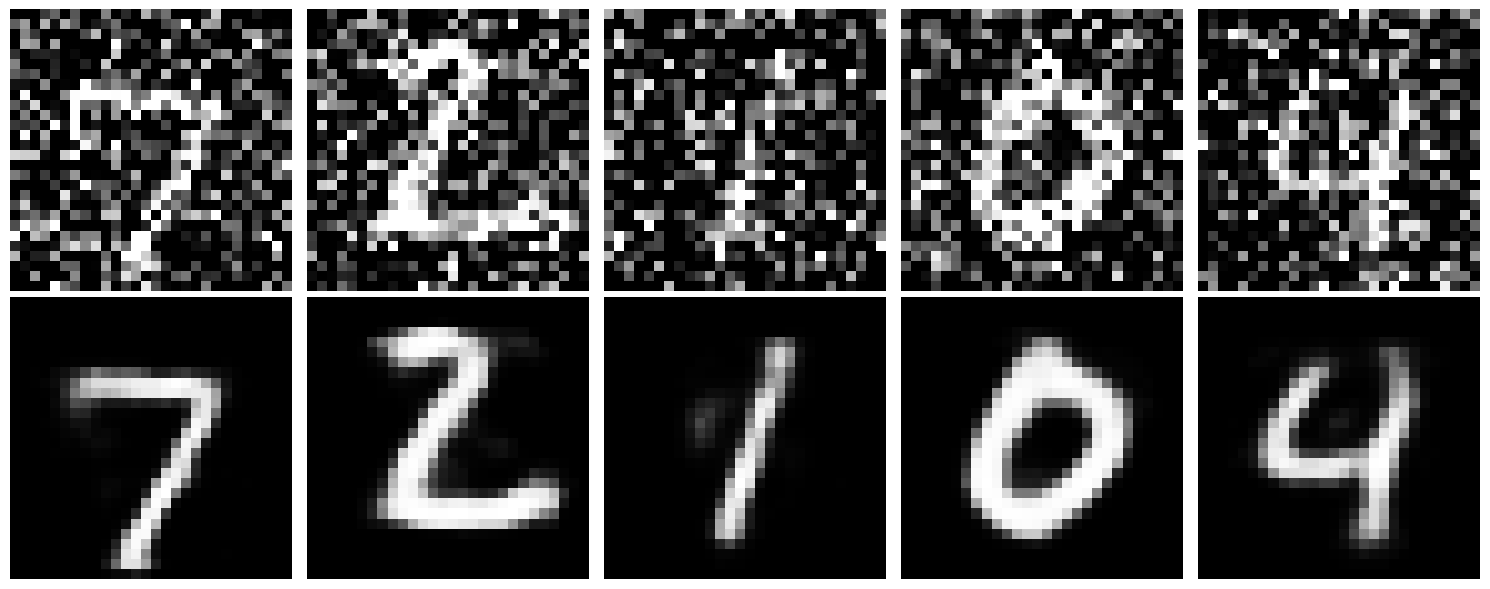

In [29]:
# Load N images from test dataset
images = next(iter(test_loader))[0][:5].to(DEVICE)

# Flatten input images
flattened_images = flatten_images(images)

# Add noise to images
flattened_noisy_images = add_noise_to_tensors(flattened_images)

# Run noisy images through model
flattened_denoised_images = model(flattened_noisy_images)

# Unflatten noisy and denoised images
noisy_images = unflatten_images(flattened_noisy_images)
denoised_images = unflatten_images(flattened_denoised_images)

# Show noisy (input) and denoised (output) images side by side
show_tensor_images(list(zip(noisy_images, denoised_images)))

The model has learned to denoise by compressing images into a latent space that is low dimensional enough to get rid of unessential things such as noise, and then to reconstruct back the original number from those compressed vectors.

Let's run some random noise through the decoder to observe its outputs and gain insight into the latent space's properties. In a standard denoising autoencoder, the decoder is trained to reconstruct MNIST digits from their encoded representations, not to generate new digits from arbitrary inputs. If the latent space lacked any structure, we might expect the output to resemble random noise. Conversely, if it were perfectly structured for generation (as in a Variational Autoencoder), random noise could produce clear, digit-like images with properties matching the original dataset. Let's test this to see what happens:

In [30]:
from tsilva_notebook_utils import render_video

def sample_latent_video(
    model,
    n_frames=100, # Number of frames to sample
    scale=4, # Scale of the video (MNIST digits are small, scale them up for easier visualization)
    fps=5, # How many frames to render per second
    latent_size=None
):
    latent_size = CONFIG["latent_size"] if latent_size is None else latent_size

    # Set the model in evaluation mode
    model.eval()

    # Send a batch of N samples of noise through the decoder to get a
    # reconstructed batch that hopefuly resembles a batch of mnist digits
    with torch.no_grad(): output = model.decoder(torch.randn(n_frames, latent_size).to(DEVICE))

    # Reshape batch from flattened to image shapes (width/height)
    images = unflatten_images(output)

    # Convert output into a list of frames ready
    # to be rendered (eg: rgb values, numpy format, etc)
    frames = tensor_to_image_data(images)

    # Render video and return html with video tag and base 64 video
    video_html = render_video(frames, scale=scale, fps=fps)
    return video_html

sample_latent_video(model)

Sending random noise through the decoder doesn't consistently produce recognizable MNIST digits, but the outputs often exhibit features reminiscent of characters, such as faint outlines or digit-like shapes. This suggests that the decoder has learned patterns from the MNIST training data, which influence its reconstructions even for untrained inputs. However, this doesn't indicate a fully structured latent space designed for generation; rather, it reflects the model's tendency to approximate digit-like forms based on its training, though not with the precision or consistency of a generative model.

Let's try interpolating between two actual digits and travel the latent space from one digit's representation to another:

In [31]:
from tsilva_notebook_utils import render_video
import torch
import numpy as np
import random

def render_digits_interpolation(
    model,
    data_loader,
    digit1,
    digit2,
    steps=30,
    fps=20
):
    # Set model in eval mode
    model.eval()

    # Iterate through data loader until we find both digits
    img1, img2 = None, None
    for images, labels in data_loader:
        images = images.to(DEVICE)

        # Find indices for target digits in current batch
        digit1_indices = (labels == digit1).nonzero(as_tuple=True)[0]
        digit2_indices = (labels == digit2).nonzero(as_tuple=True)[0]

        # If we found target_digit1 and haven't selected img1 yet
        if len(digit1_indices) > 0 and img1 is None:
            digit1_idx = random.choice(digit1_indices.tolist())
            img1 = images[digit1_idx:digit1_idx+1]

        # If we found target_digit2 and haven't selected img2 yet
        if len(digit2_indices) > 0 and img2 is None:
            digit2_idx = random.choice(digit2_indices.tolist())
            img2 = images[digit2_idx:digit2_idx+1]

        # If we have both images, we can break
        if img1 is not None and img2 is not None: break

    # Disable gradient tracking during inference
    with torch.no_grad():
        # Encode both images to latent space
        img1 = flatten_images(img1)
        img2 = flatten_images(img2)
        latent1 = model.encoder(img1)
        latent2 = model.encoder(img2)

        # Create interpolated frames by creating an interpolated
        # latent for each frame and decoding it back to image space
        frames = []
        for alpha in np.linspace(0, 1, steps):
            # Mix percentage of first latent with percentage of second latent
            interpolated_latent = (1 - alpha) * latent1 + alpha * latent2

            # Decode back to image space
            interpolated_img = model.decoder(interpolated_latent)
            interpolated_img = unflatten_images(interpolated_img)

            # Convert to numpy array with proper scaling and type
            frame = tensor_to_image_data(interpolated_img)
            frames.append(frame)

    # Render video
    return render_video(frames, scale=4, fps=fps)

# Render video interpolating from 1 to 9
render_digits_interpolation(model, test_loader, 1, 9)

Not too bad. The denoising autoencoder maps MNIST digits into a latent space where their structural features—like strokes and shapes—are preserved, allowing linear interpolation between two digits (even from different classes, like '1' and '9') to produce meaningful, digit-like frames. This works well here because MNIST digits share a simple, consistent format (grayscale, centered, 28x28). In more complex datasets, such as real-life images with diverse backgrounds and variations, a standard autoencoder might struggle to decode smooth or recognizable transitions during interpolation, though advanced models like VAEs could still achieve meaningful results with proper training.

Finally, let's create an interactive Gradio interface that allows you to experiment with interpolating between different digits in the latent space:


In [32]:
import gradio as gr

def build_gradio_ui(model, test_loader):
    def _render_digits_interpolation(source_digit, target_digit, steps, fps):
        return render_digits_interpolation(model, test_loader, source_digit, target_digit, steps, fps).data

    with gr.Blocks() as demo:
        with gr.Row():
            digit1 = gr.Dropdown(
                choices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                label="Source Digit",
                value=1
            )
            digit2 = gr.Dropdown(
                choices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                label="Target Digit",
                value=9
            )

        with gr.Row():
            steps = gr.Slider(
                minimum=10,
                maximum=100,
                step=1,
                value=30,
                label="Number of Steps"
            )
            fps = gr.Slider(
                minimum=5,
                maximum=60,
                step=1,
                value=20,
                label="Frames Per Second"
            )

        generate_btn = gr.Button("Generate Interpolation")
        output = gr.HTML(label="Interpolation Result")

        generate_btn.click(
            fn=_render_digits_interpolation,
            inputs=[digit1, digit2, steps, fps],
            outputs=output
        )

    return demo

interface = build_gradio_ui(model, test_loader)
interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://cf9b38f2652e0c4ae4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
